The dataset provided in this project contains the annual spend amount of each of the 20,000 customers of a major retail company. The marketing team of the company used different channels to sell their goods and has segregated customers based on the purchases made using different channels, which are as follows:

* 0: Retail
* 1: Roadshow
* 2: Social media
* 3: Television

This project is tasked with building a machine learning model that will be able to predict the most effective channel that can be used to target a customer based on the annual spend on the following six products (features) sold by the company: fresh produce, milk, groceries, frozen produce, detergents paper, and delicatessen.

Google Data Studio Dashboard

https://datastudio.google.com/reporting/022a6180-f063-4271-a807-b0a5a7a09ba0

Streamlit link

https://share.streamlit.io/taylorec/marketing_analytics_sales_channels/main/Sales_Channels.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn import metrics 
from sklearn.metrics import precision_recall_fscore_support 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [ ]:
data= pd.read_csv('/content/drive/MyDrive/Marketing-Analytics/Data/MarketingData.csv')
data.head(5)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Channel
0,1258.486572,882.094918,1264.002044,963.826561,1238.718727,984.054640,2
1,1072.083074,932.778650,831.671388,725.903493,734.751835,822.210421,2
2,1005.494853,1061.499289,933.310379,831.008623,685.732184,928.636436,2
3,1063.093306,760.777712,625.349867,588.623463,757.945557,811.041868,0
4,974.071721,961.543853,800.429688,806.499716,804.198535,968.523456,2


In [ ]:
data.shape

(20000, 7)

In [ ]:
data.isnull().values.any()

False

In [ ]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Channel
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1112.136536,842.859819,1023.406092,832.911220,1005.129674,1066.597715,1.499350
std,214.390356,188.410111,265.771756,207.556977,242.483280,255.311190,1.118464
min,0.190000,0.160000,0.210000,0.170000,0.210000,0.190000,0.000000
25%,979.497396,710.106782,836.496608,692.239528,814.368135,894.060614,0.000000
50%,1137.856840,854.038612,1013.901084,858.176913,1019.984803,1030.918864,1.000000
75%,1249.040190,973.080829,1214.848500,966.429067,1176.450667,1249.113400,3.000000
max,1900.000000,1600.000000,2100.000000,1700.000000,2100.000000,1900.000000,3.000000


In [ ]:
data['Channel'].value_counts()

# the sales channels are evenly distributed

0    5007
3    5002
1    5001
2    4990
Name: Channel, dtype: int64

### Save data to GCS bucket

In [ ]:
Data_Studio_df = data.copy()
Data_Studio_df['Channel'] = Data_Studio_df['Channel'].map({0:'Retail', 1:'Roadshow', 2:'Social Media', 3:'Television'})

In [ ]:
Data_Studio_df['Channel'].value_counts()

Retail          5007
Television      5002
Roadshow        5001
Social Media    4990
Name: Channel, dtype: int64

In [ ]:
project_id = 'sixth-flag-316719'

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
Data_Studio_df.to_csv('Sales_channels.csv')

!gcloud config set project {project_id}

import uuid

bucket_name = 'marketing_data_analytics'

!gsutil mb gs://{bucket_name}

!gsutil cp Sales_channels.csv gs://{bucket_name}/

Updated property [core/project].
Creating gs://marketing_data_analytics/...
ServiceException: 409 A Cloud Storage bucket named 'marketing_data_analytics' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Copying file://Sales_channels.csv [Content-Type=text/csv]...
/ [1 files][  1.6 MiB/  1.6 MiB]                                                
Operation completed over 1 objects/1.6 MiB.                                      


### Model the data

In [ ]:
target = 'Channel'
X = data.drop(['Channel'],axis=1)
y=data[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values,y, test_size=0.20, random_state=123, stratify=y)

**Random Forest**

The  random forest  algorithm reduces variance/overfitting by averaging multiple decision trees, which individually suffer from high variance.

Random Forest Algorithm:
1. A random bootstrap sample (a sample drawn with replacement) of size m is chosen from the training data. This splits the training data into subsets such as Data1, Data2, and so on. 
2. Decision trees are grown on each instance of the bootstrap. These decision trees can be referred to as Learner1, Learner2, and so on. 
3. d features are chosen randomly without replacement. 
4. Each node is split using the d features selected based on objective functions, which could be information gain. 
5. Steps 1-4 are repeated k times. Eventually, this generates Model1, Model2, and so on for each subset.
6. All of the predictions from the multiple trees are aggregated and assigned a class label by majority vote.

The thumb rule for variable selection of m variables out of total variables p, is m = sqrt(p) for classification and m = p/3 for regression problems randomly to avoid correlation among the individual trees. By doing so, significant improvement in accuracies can be achieved.

In [ ]:
clf_random = RandomForestClassifier(n_estimators=20, \
                    max_depth=None, \
                    min_samples_split=7, \
                    random_state=0)

In [ ]:
clf_random.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=7, n_estimators=20, random_state=0)

In [ ]:
y_pred=clf_random.predict(X_test)

In [ ]:
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.8888143115382328, 0.8885103588795973, 0.888619538273321, None)

In [ ]:
precision_recall_fscore_support(y_test, y_pred, average='micro')

(0.8885, 0.8885, 0.8885, None)

In [ ]:
target_names = ["Retail","RoadShow","SocialMedia","Televison"]
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

      Retail       0.90      0.90      0.90      1001
    RoadShow       0.86      0.86      0.86      1000
 SocialMedia       0.93      0.91      0.92       998
   Televison       0.87      0.89      0.88      1001

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



In [ ]:
cm = confusion_matrix(y_test, y_pred) 

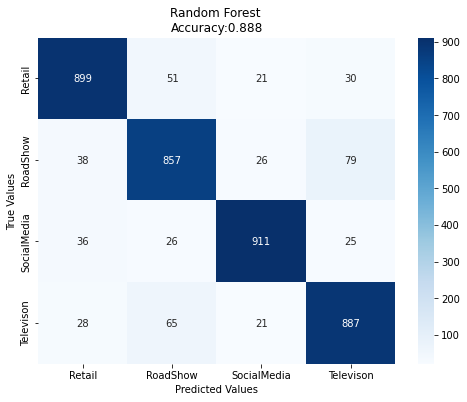

In [ ]:
cm_df = pd.DataFrame(cm,\
            index = target_names,\
            columns = target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt='g',cmap='Blues')
plt.title('Random Forest \nAccuracy:{0:.3f}'\
    .format(accuracy_score(y_test, y_pred)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

The predictive accuracy is high for all four channels. 

**Gradient Boosting**

Gradient boosting classifier works on the principle of boosting weak learners iteratively by shifting focus towards problematic observations that were difficult to predict in previous iterations and performing an ensemble of weak learners, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, but generalizes them by allowing optimization of an arbitrary differentiable loss function.

Gradient boosting steps:
  1. fit the model on observations producing $P_0$% accuracy; the remaining unexplained variance is captured in the error term: $Y = F(x) + error$
  2. fit another model on the error term to pull the extra explanatory component and add it to the original model, which should improve the overall accuracy: $error = G(x) + error2$
  3. the model will improve to $P_1$% accuracy and the equation looks as follows: $Y = F(x) + G(x) + error2$
  4. continue this method one more time to fit a model on the $error2$ component to extract a further explanatory component: $error2 = H(x) + error3$
  5. model accuracy is again improved to $P_2$% and the final model equation looks as follows: $Y = F(x) + G(x) + H(x) + error3$
  6. Gradient boosting improves results further by using weighted average (higher importance given to better models that predict results with greater accuracy than others) $Y = a*G(x) + B*G(x) + 𝛶*H(x) + error4$

Gradient boosting involves three elements:
 * Loss function to be optimized: Loss function depends on the type of problem being solved. In the case of regression problems, mean squared error is used, and in classification problems, logarithmic loss will be used. In boosting, at each stage, unexplained loss from prior iterations will be optimized rather than starting from scratch.
 * Weak learner to make predictions: Decision trees are used as a weak learner in gradient boosting.
 * Additive model to add weak learners to minimize the loss function: Trees are added one at a time and existing trees in the model are not changed. The gradient descent procedure is used to minimize the loss when adding trees.

Gradient Boosting Algorithm:
 1. Initialize: initializes the constant optimal constant model, which is just a single terminal node that will be utilized as a starting point to tune it further in next steps. $f_0(x) = argmin_y \sum^{N}_{i=1}L(y_i,𝛶)$
 2. For m = 1 to M:
  * For i = 1, 2, …, N compute: calculate the residuals/errors by comparing actual outcome with predicted results $ 𝑟_{im} = -[\frac{∂L(y_i,f(x_i))}{∂f(x_i)} ]f = f_{m-1}$
  * Fit a regression tree to the targets $r_{im}$ giving terminal regions $R_{jm}$, $j$ = 1, 2, …, $J_m$: the next decision tree will be fitted on error terms to bring in more explanatory power to the model. 
  * For $j$ = 1, 2, …, $J_m$, compute: the next decision tree will be fitted on error terms to bring in more explanatory power to the model $ 𝛶_{jm} = argmin_{𝛶} \sum_{x_i \in R_{jm}} L(y_i, f_{m-1}(x_i)+𝛶) $
  * d) Update: add the extra component to the model at last iteration. $ f_m(x) = f_{m-1}(x) + ∑^{J_m}_{j=1} 𝛶_{jm}I(x \in R_{jm}) $
 3. Output: ensemble all weak learners to create a strong learner. $ \hat{f}(x) = f_m(x) $ 


In [ ]:
Gbr = GradientBoostingClassifier(n_estimators=480).fit(X_train,y_train)

In [ ]:
y_pred2=Gbr.predict(X_test)

In [ ]:
precision_recall_fscore_support(y_test, y_pred2, average='macro')

(0.868511506575564, 0.8682573303450056, 0.8682977091280147, None)

In [ ]:
precision_recall_fscore_support(y_test, y_pred, average='micro')

(0.8885, 0.8885, 0.8885, None)

In [ ]:
target_names = ["Retail","RoadShow","SocialMedia","Televison"]
print(classification_report(y_test, y_pred2,target_names=target_names))

              precision    recall  f1-score   support

      Retail       0.89      0.88      0.88      1001
    RoadShow       0.84      0.83      0.83      1000
 SocialMedia       0.90      0.89      0.90       998
   Televison       0.85      0.88      0.86      1001

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



In [ ]:
cm2 = confusion_matrix(y_test, y_pred2) 

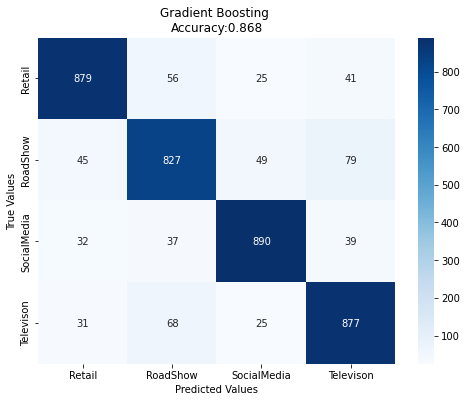

In [ ]:
cm_df2 = pd.DataFrame(cm2,\
            index = target_names,\
            columns = target_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm_df2, annot=True,fmt='g',cmap='Blues')
plt.title('Gradient Boosting \nAccuracy:{0:.3f}'\
    .format(accuracy_score(y_test, y_pred2)))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

Random Forest performed better than Gradient Boosting. 

In [ ]:
importances = clf_random.feature_importances_

In [ ]:
indices = np.argsort(importances)
Features = X.columns
Features

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper',
       'Delicatessen'],
      dtype='object')

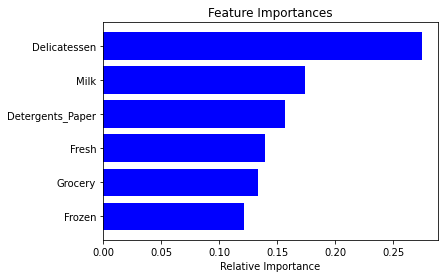

In [ ]:
import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [Features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The above plot shows the feature importance of this model in order from most to least impactful.

### Save model

In [ ]:
import joblib

In [ ]:
# Save model to Drive

joblib.dump(clf_random,'/content/drive/MyDrive/Marketing-Analytics/Models/SC_model.joblib')

['/content/drive/MyDrive/Marketing-Analytics/Models/SC_model.joblib']